In [1]:
pip install catboost

You should consider upgrading via the 'c:\Users\양태영\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install xgboost lightgbm mlxtend statsmodels scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\양태영\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\양태영\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install seaborn matplotlib joblib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\양태영\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import time
import shap

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

c:\Users\양태영\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


데이터 준비


In [7]:
gwangju_data = pd.read_csv("Gwangju.csv")
busan_data = pd.read_csv("Busan.csv")
daegu_data = pd.read_csv("Daegu.csv")
daejeon_data = pd.read_csv("Daejeon.csv")
incheon_data = pd.read_csv("Incheon.csv")
seoul_data = pd.read_csv("Seoul.csv")

데이터 전처리

In [8]:
# 이상치 제거 행, 누락된 timestemp에 해당하는 데이터 선형보간으로 채우기 

def preprocess_cleaned(data, solar_outlier=6):
    """
    데이터 전처리: 이상치 제거, 누락된 시간 채우기, 선형 보간 수행, Datetime 재구성.
    
    Parameters:
    - data (pd.DataFrame): 원본 데이터프레임.
    - solar_outlier (float): 제거할 Solar 값 기준.
    
    Returns:
    - pd.DataFrame: 전처리된 데이터프레임 (Year, Month, Day, Hour 복원).
    """
    # Step 1: Datetime 생성
    data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])

    # Step 2: 이상치 제거
    data = data[data['Solar'] != solar_outlier]

    # Step 3: 누락된 시간 채우기
    full_range = []
    full_days = pd.date_range(start=data['Datetime'].min().date(),
                              end=data['Datetime'].max().date(),
                              freq='D')
    for day in full_days:
        for hour in range(8, 19):  # 시간 범위: 08시 ~ 18시
            full_range.append(pd.Timestamp(day) + pd.Timedelta(hours=hour))
    full_range = pd.DatetimeIndex(full_range)
    full_data = pd.DataFrame({'Datetime': full_range})

    # Step 4: 병합 (Datetime 기준)
    merged_data = full_data.merge(data, on='Datetime', how='left')

    # Step 5: 선형 보간 (Datetime 제외)
    for col in merged_data.columns:
        if col != 'Datetime':
            merged_data[col] = merged_data[col].interpolate(method='linear')

    # Step 6: Datetime에서 Year, Month, Day, Hour 복원
    merged_data['Year'] = merged_data['Datetime'].dt.year
    merged_data['Month'] = merged_data['Datetime'].dt.month
    merged_data['Day'] = merged_data['Datetime'].dt.day
    merged_data['Hour'] = merged_data['Datetime'].dt.hour

    # Step 7: Datetime 제거 (필요시 유지 가능)
    merged_data.drop(columns=['Datetime'], inplace=True)

    return merged_data

In [9]:
gwangju_data_cleaned = preprocess_cleaned(gwangju_data)
gwangju_data_cleaned.to_csv("Gwangju_cleaned.csv", index=False)

busan_data_cleaned = preprocess_cleaned(busan_data)
busan_data_cleaned.to_csv("Busan_cleaned.csv", index=False)

daegu_data_cleaned = preprocess_cleaned(daegu_data)
daegu_data_cleaned.to_csv("Daegu_cleaned.csv", index=False)

daejeon_data_cleaned = preprocess_cleaned(daejeon_data)
daejeon_data_cleaned.to_csv("Daejeon_cleaned.csv", index=False)

incheon_data_cleaned = preprocess_cleaned(incheon_data)
incheon_data_cleaned.to_csv("Incheon_cleaned.csv", index=False)

seoul_data_cleaned = preprocess_cleaned(seoul_data)
seoul_data_cleaned.to_csv("Seoul_cleaned.csv", index=False)

In [11]:
gwangju_data_cleaned=pd.read_csv("Gwangju_cleaned.csv")

busan_data_cleaned = pd.read_csv("Busan_cleaned.csv")

daegu_data_cleaned = pd.read_csv("Daegu_cleaned.csv")

daejeon_data_cleaned = pd.read_csv("Daejeon_cleaned.csv")

incheon_data_cleaned = pd.read_csv("Incheon_cleaned.csv")

seoul_data_cleaned = pd.read_csv("Seoul_cleaned.csv")

In [12]:
"""
    최종 전처리 함수
    - Day_sin, Day_cos 주기 변수 생성
    - Hour를 원핫 인코딩 (T8 ~ T18).
    - 전날의 Temp, Humi, WS, Solar 데이터를 추가
    """
def preprocess_time(data):
    
    # Timestamp 생성 및 Day_sin, Day_cos 생성
    data['Timestamp'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
    data['Day_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofyear / 365)
    data['Day_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofyear / 365)
    
    # Hour 원핫 인코딩 (T8 ~ T18)
    hour_dummies = pd.get_dummies(data['Hour'], prefix='', prefix_sep='')
    hour_dummies.columns = ['T' + col for col in hour_dummies.columns.astype(str)]
    hour_dummies = hour_dummies.astype(int)
    data = pd.concat([data, hour_dummies], axis=1)
    
    # 전날 데이터 추가 (D1_Temp, D1_Humi, D1_WS, D1_Solar)
    data['D1_Temp'] = data['Temp'].shift(11, fill_value=0)  # 전날 08:00의 Temp, 기본값 0
    data['D1_Humi'] = data['Humi'].shift(11, fill_value=0)  # 전날 08:00의 Humi, 기본값 0
    data['D1_WS'] = data['WS'].shift(11, fill_value=0)      # 전날 08:00의 WS, 기본값 0
    data['D1_Solar'] = data['Solar'].shift(11, fill_value=0)  # 전날 08:00의 Solar, 기본값 0
    
    # 불필요한 컬럼 제거
    data.drop(columns=['Timestamp', 'Year', 'Month', 'Day', 'Hour'], inplace=True)
    
    # 결과 반환
    return data

In [13]:
gwangju_preprocess = preprocess_time(gwangju_data_cleaned)
gwangju_preprocess.to_csv("Gwangju_preprocess.csv", index=False)

busan_preprocess = preprocess_time(busan_data_cleaned)
busan_preprocess.to_csv("Busan_preprocess.csv", index=False)

daegu_preprocess = preprocess_time(daegu_data_cleaned)
daegu_preprocess.to_csv("Daegu_preprocess.csv", index=False)

daejeon_preprocess = preprocess_time(daejeon_data_cleaned)
daejeon_preprocess.to_csv("Daejeon_preprocess.csv", index=False)

incheon_preprocess = preprocess_time(incheon_data_cleaned)
incheon_preprocess.to_csv("Incheon_preprocess.csv", index=False)

seoul_preprocess = preprocess_time(seoul_data_cleaned)
seoul_preprocess.to_csv("Seoul_preprocess.csv", index=False)

In [14]:
gwangju_preprocessed = pd.read_csv("Gwangju_preprocess.csv")

busan_preprocessed = pd.read_csv("Busan_preprocess.csv")

daegu_preprocessed = pd.read_csv("Daegu_preprocess.csv")

daejeon_preprocessed = pd.read_csv("Daejeon_preprocess.csv")

incheon_preprocessed = pd.read_csv("Incheon_preprocess.csv")

seoul_preprocessed = pd.read_csv("Seoul_preprocess.csv")

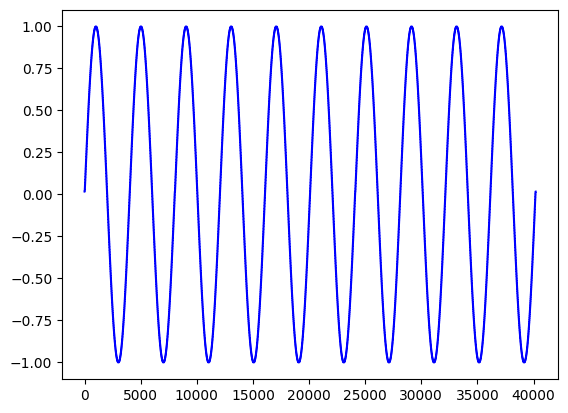

In [15]:
# 사인 값 시각화
plt.plot(gwangju_preprocessed['Day_sin'], label='sin(day)', color='blue')

In [ ]:
# 사인 값 시각화
plt.plot(gwangju_preprocessed['Day_cos'], label='cos(day)', color='blue')